In [2]:
import os
from codecarbon import EmissionsTracker
import numpy as np
import time
from datetime import datetime
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [5]:
# dataset loader
def load_data_by_dimension(dimension, dataset_path=""):
    root = os.path.join(dataset_path, "./datasets/")
    data_filename = root + f'kryptonite-{dimension}-X.npy'
    labels_filename = root + f'kryptonite-{dimension}-y.npy'
    data = np.load(data_filename)
    labels = np.load(labels_filename)
    print(f"Loaded dataset with dimension {dimension}. Data shape: {data.shape}, Labels shape: {labels.shape}")
    return data, labels

In [6]:
cs = {
    "layer_width": tune.choice([4, 8, 16, 24, 32]),
    "layer_depth": tune.randint(2, 4),
    "activation": tune.choice(['relu', 'tanh']),
    "lr": tune.loguniform(1e-4, 1e-2),
    "momentum": tune.uniform(0.1, 0.9),
}  # hyper-parameter search space


# the function used in search
def objective(config):
    data, labels = load_data_by_dimension(objective.dim, objective.dataset_path)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    # Scale the data
    sc = StandardScaler()
    scaler = sc.fit(X_train)
    trainX_scaled = scaler.transform(X_train)
    testX_scaled = scaler.transform(X_test)
    # Build the model
    layers = [config["layer_width"]] * config["layer_depth"]
    print(f"Training with layers: {layers} and activation function: {config['activation']}")
    model = MLPClassifier(hidden_layer_sizes=layers, max_iter=1000, activation=config["activation"],
                          learning_rate_init=config["lr"], momentum=config["momentum"])
    # Report the accuracy result
    while True:
        model.fit(trainX_scaled, y_train)
        acc = model.score(testX_scaled, y_test)
        train.report({"mean_accuracy": acc})  # Report to Tune

In [7]:
# Hyperparameter search
def search(dim):
    algo = OptunaSearch()
    # Set function attributes
    objective.dim = dim
    objective.dataset_path = os.getcwd()
    # Configure the tuner
    tuner = tune.Tuner(
        objective,
        tune_config=tune.TuneConfig(
            metric="mean_accuracy",
            mode="max",
            search_alg=algo,
            num_samples=-1,
            time_budget_s=60 * 10,
            trial_dirname_creator=lambda x: datetime.now().strftime("%H_%M_%S")
        ),
        run_config=train.RunConfig(
            storage_path=os.path.join(os.getcwd(), "./results"),  # store trail runs' details
            name="simpleneuralnetwork",
            verbose=0,
        ),
        param_space=cs,
    )
    # Run the tuner
    begin = time.time()
    results = tuner.fit()
    end = time.time() - begin
    # Get the best result
    best_result = results.get_best_result(metric="mean_accuracy", mode="max")
    best_config = best_result.config
    # Print the results
    print("auto optimization finished")
    print('time for optimisation (seconds):' + str(end))
    print("Best trial config: {}".format(best_config))
    print("Best accuracy: {}".format(best_result.metrics["mean_accuracy"]))
    return best_config

In [ ]:
# Pre-defined dimensions in use
dimensions = [9, 12, 15, 18, 24, 30, 45]
accuracies = []

# Search for the best configuration for each dimension
tracker = EmissionsTracker()
tracker.start()
for dim in dimensions:
    # Search for the best configuration
    best = search(dim)
    # Save the configuration
    with open(f"./results/best_config_dim{dim}.json", "w") as f:
        json.dump(best, f)
emissions = tracker.stop()

(objective pid=15533) Training with layers: [24, 24, 24] and activation function: relu
(objective pid=17048) Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)
(objective pid=17048) Training with layers: [32, 32, 32] and activation function: tanh
(objective pid=17108) Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


[codecarbon INFO @ 21:55:01] Energy consumed for RAM : 0.002839 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 21:55:01] Energy consumed for all GPUs : 0.011761 kWh. Total GPU Power : 10.437456560970151 W
[codecarbon INFO @ 21:55:01] Energy consumed for all CPUs : 0.027566 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 21:55:01] 0.042167 kWh of electricity used since the beginning.


(objective pid=17168) Training with layers: [24, 24, 24] and activation function: relu
(objective pid=17168) 
(objective pid=17232) Training with layers: [24, 24, 24] and activation function: tanh [repeated 2x across cluster]
(objective pid=17292) Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,) [repeated 3x across cluster]
(objective pid=17292) Training with layers: [24, 24] and activation function: relu
(objective pid=17421) Training with layers: [32, 32] and activation function: tanh [repeated 2x across cluster]
(objective pid=17486) Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,) [repeated 3x across cluster]
(objective pid=17486) Training with layers: [16, 16] and activation function: relu


[codecarbon INFO @ 21:55:16] Energy consumed for RAM : 0.002851 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 21:55:16] Energy consumed for all GPUs : 0.011805 kWh. Total GPU Power : 10.386260262029051 W
[codecarbon INFO @ 21:55:16] Energy consumed for all CPUs : 0.027679 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 21:55:16] 0.042334 kWh of electricity used since the beginning.


(objective pid=17608) Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,) [repeated 2x across cluster]
(objective pid=17544) Training with layers: [32, 32] and activation function: relu
(objective pid=17608) Training with layers: [16, 16] and activation function: relu
(objective pid=17738) Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,) [repeated 2x across cluster]
(objective pid=17674) Training with layers: [8, 8, 8] and activation function: relu
(objective pid=17738) Training with layers: [32, 32] and activation function: relu
(objective pid=17873) Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,) [repeated 2x across cluster]
(objective pid=17802) Training with layers: [8, 8, 8] and activation function: relu
(objective pid=17873) Training with layers: [32, 32, 32] and activation function: relu


[codecarbon INFO @ 21:55:31] Energy consumed for RAM : 0.002862 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 21:55:31] Energy consumed for all GPUs : 0.011848 kWh. Total GPU Power : 10.413724178190686 W
[codecarbon INFO @ 21:55:31] Energy consumed for all CPUs : 0.027791 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 21:55:31] 0.042502 kWh of electricity used since the beginning.


(objective pid=17938) Training with layers: [32, 32, 32] and activation function: tanh
(objective pid=18007) Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,) [repeated 2x across cluster]
(objective pid=18007) Training with layers: [32, 32, 32] and activation function: relu


[codecarbon INFO @ 21:55:46] Energy consumed for RAM : 0.002874 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 21:55:46] Energy consumed for all GPUs : 0.011892 kWh. Total GPU Power : 10.479770852863668 W
[codecarbon INFO @ 21:55:46] Energy consumed for all CPUs : 0.027904 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 21:55:46] 0.042669 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:46] 0.002653 g.CO2eq/s mean an estimation of 83.67751691425973 kg.CO2eq/year
[codecarbon INFO @ 21:56:01] Energy consumed for RAM : 0.002886 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 21:56:01] Energy consumed for all GPUs : 0.011935 kWh. Total GPU Power : 10.379056964599048 W
[codecarbon INFO @ 21:56:01] Energy consumed for all CPUs : 0.028016 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 21:56:01] 0.042837 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:56:16] Energy consumed for RAM : 0.002897 kWh. RAM Power : 2.789916515350342 W
[code

auto optimization finished
time for optimisation (seconds):611.9501886367798
Best trial config: {'layer_width': 32, 'layer_depth': 2, 'activation': 'tanh', 'lr': 0.003109617890583199, 'momentum': 0.5081564247103649}
Best accuracy: 0.5048888888888889


/home/jjluhilson/.local/lib/python3.10/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


: 

In [6]:
# Get mean and standard deviation of the best configurations
dimensions = [9, 12, 15, 18, 24, 30, 45]
means = []
std_devs = []
# Loop for each dimension
with EmissionsTracker() as tracker2:
    for dim in dimensions:
        # Load the best configuration
        with open(f"./results/best_config_dim{dim}.json", "r") as f:
            best = json.load(f)
        # Load the data
        data, labels = load_data_by_dimension(dim)
        accuracies = []
        # Run the model 10 times with difference train-test splits
        for i in range(10):
            X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
            sc = StandardScaler()
            scaler = sc.fit(X_train)
            trainX_scaled = scaler.transform(X_train)
            testX_scaled = scaler.transform(X_test)
            layers = [best["layer_width"]] * best["layer_depth"]
            model = MLPClassifier(hidden_layer_sizes=layers, max_iter=1000, activation=best["activation"],
                              learning_rate_init=best["lr"], momentum=best["momentum"])
            model.fit(trainX_scaled, y_train)
            accuracy = model.score(testX_scaled, y_test)
            accuracies.append(accuracy)
        # Record the mean and standard deviation of the run
        accuracies = np.array(accuracies)
        means.append(np.mean(accuracies))
        std_devs.append(np.std(accuracies))

[codecarbon INFO @ 22:11:54] [setup] RAM Tracking...
[codecarbon INFO @ 22:11:54] [setup] GPU Tracking...
[codecarbon INFO @ 22:11:54] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:11:54] [setup] CPU Tracking...
[codecarbon WARNING @ 22:11:54] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon INFO @ 22:11:56] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 22:11:56] >>> Tracker's metadata:
[codecarbon INFO @ 22:11:56]   Platform system: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.35
[codecarbon INFO @ 22:11:56]   Python version: 3.10.12
[codecarbon INFO @ 22:11:56]   CodeCarbon version: 2.7.4
[codecarbon INFO @ 22:11:56]   Available RAM : 7.440 GB
[codecarbon INFO @ 22:11:56]   CPU count: 16
[codecarbon INFO @ 22:11:56]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)


[codecarbon INFO @ 22:12:14] Energy consumed for RAM : 0.000012 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:12:14] Energy consumed for all GPUs : 0.000040 kWh. Total GPU Power : 9.579382796499912 W
[codecarbon INFO @ 22:12:14] Energy consumed for all CPUs : 0.000113 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:12:14] 0.000164 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:12:29] Energy consumed for RAM : 0.000023 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:12:29] Energy consumed for all GPUs : 0.000081 kWh. Total GPU Power : 9.90056035207004 W
[codecarbon INFO @ 22:12:29] Energy consumed for all CPUs : 0.000225 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:12:29] 0.000329 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:12:44] Energy consumed for RAM : 0.000035 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:12:44] Energy consumed for all GPUs : 0.000122 kWh. Total GPU Power : 9.798077715492884 

Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)


[codecarbon INFO @ 22:14:44] Energy consumed for RAM : 0.000128 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:14:44] Energy consumed for all GPUs : 0.000452 kWh. Total GPU Power : 10.683537414664247 W
[codecarbon INFO @ 22:14:44] Energy consumed for all CPUs : 0.001237 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:14:44] 0.001817 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:14:59] Energy consumed for RAM : 0.000139 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:14:59] Energy consumed for all GPUs : 0.000493 kWh. Total GPU Power : 9.942582311929602 W
[codecarbon INFO @ 22:14:59] Energy consumed for all CPUs : 0.001350 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:14:59] 0.001982 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:15:14] Energy consumed for RAM : 0.000151 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:15:14] Energy consumed for all GPUs : 0.000533 kWh. Total GPU Power : 9.69823161238747

Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)


[codecarbon INFO @ 22:18:44] Energy consumed for RAM : 0.000314 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:18:44] Energy consumed for all GPUs : 0.001111 kWh. Total GPU Power : 10.085331629340434 W
[codecarbon INFO @ 22:18:44] Energy consumed for all CPUs : 0.003037 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:18:44] 0.004462 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:18:59] Energy consumed for RAM : 0.000325 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:18:59] Energy consumed for all GPUs : 0.001153 kWh. Total GPU Power : 10.193055816698871 W
[codecarbon INFO @ 22:18:59] Energy consumed for all CPUs : 0.003150 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:18:59] 0.004628 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:19:14] Energy consumed for RAM : 0.000337 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:19:14] Energy consumed for all GPUs : 0.001198 kWh. Total GPU Power : 10.678103951411

Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)


[codecarbon INFO @ 22:20:59] Energy consumed for RAM : 0.000418 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:20:59] Energy consumed for all GPUs : 0.001490 kWh. Total GPU Power : 10.477269653890492 W
[codecarbon INFO @ 22:20:59] Energy consumed for all CPUs : 0.004050 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:20:59] 0.005958 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:21:14] Energy consumed for RAM : 0.000430 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:21:14] Energy consumed for all GPUs : 0.001533 kWh. Total GPU Power : 10.298265797320843 W
[codecarbon INFO @ 22:21:14] Energy consumed for all CPUs : 0.004162 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:21:14] 0.006125 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:21:29] Energy consumed for RAM : 0.000442 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:21:29] Energy consumed for all GPUs : 0.001578 kWh. Total GPU Power : 10.709084627802

Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)


[codecarbon INFO @ 22:27:59] Energy consumed for RAM : 0.000744 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:27:59] Energy consumed for all GPUs : 0.002648 kWh. Total GPU Power : 9.230750979527603 W
[codecarbon INFO @ 22:27:59] Energy consumed for all CPUs : 0.007199 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:27:59] 0.010591 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:27:59] 0.002619 g.CO2eq/s mean an estimation of 82.59288527437441 kg.CO2eq/year
[codecarbon INFO @ 22:28:14] Energy consumed for RAM : 0.000755 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:28:14] Energy consumed for all GPUs : 0.002688 kWh. Total GPU Power : 9.797681414029931 W
[codecarbon INFO @ 22:28:14] Energy consumed for all CPUs : 0.007312 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:28:14] 0.010756 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:28:29] Energy consumed for RAM : 0.000767 kWh. RAM Power : 2.789916515350342 W
[codeca

Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)


[codecarbon INFO @ 22:29:44] Energy consumed for RAM : 0.000825 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:29:44] Energy consumed for all GPUs : 0.002940 kWh. Total GPU Power : 10.196239333045574 W
[codecarbon INFO @ 22:29:44] Energy consumed for all CPUs : 0.007987 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:29:44] 0.011752 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:29:59] Energy consumed for RAM : 0.000837 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:29:59] Energy consumed for all GPUs : 0.002982 kWh. Total GPU Power : 10.039329933705385 W
[codecarbon INFO @ 22:29:59] Energy consumed for all CPUs : 0.008099 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:29:59] 0.011918 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:29:59] 0.002627 g.CO2eq/s mean an estimation of 82.84048993998937 kg.CO2eq/year
[codecarbon INFO @ 22:30:14] Energy consumed for RAM : 0.000848 kWh. RAM Power : 2.789916515350342 W
[code

Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


[codecarbon INFO @ 22:33:29] Energy consumed for RAM : 0.000999 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:33:29] Energy consumed for all GPUs : 0.003554 kWh. Total GPU Power : 9.810897101258522 W
[codecarbon INFO @ 22:33:29] Energy consumed for all CPUs : 0.009674 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:33:29] 0.014227 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:33:44] Energy consumed for RAM : 0.001011 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:33:44] Energy consumed for all GPUs : 0.003598 kWh. Total GPU Power : 10.515689805227534 W
[codecarbon INFO @ 22:33:44] Energy consumed for all CPUs : 0.009787 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 22:33:44] 0.014395 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:33:59] Energy consumed for RAM : 0.001023 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 22:33:59] Energy consumed for all GPUs : 0.003641 kWh. Total GPU Power : 10.3561576660397

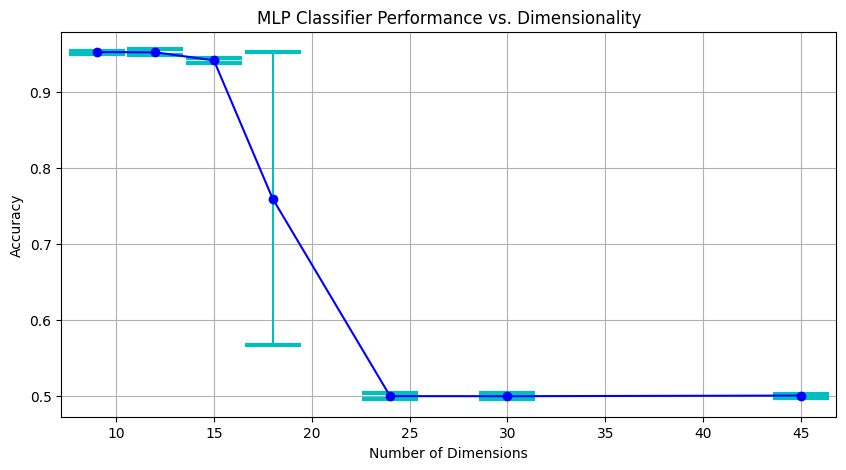

In [7]:
# Plot the performance of models and show the standard deviation
plt.figure(figsize=(10, 5))
plt.errorbar(dimensions, means, yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=20, capthick=3)
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy')
plt.title('MLP Classifier Performance vs. Dimensionality')
plt.grid(True)
plt.show()

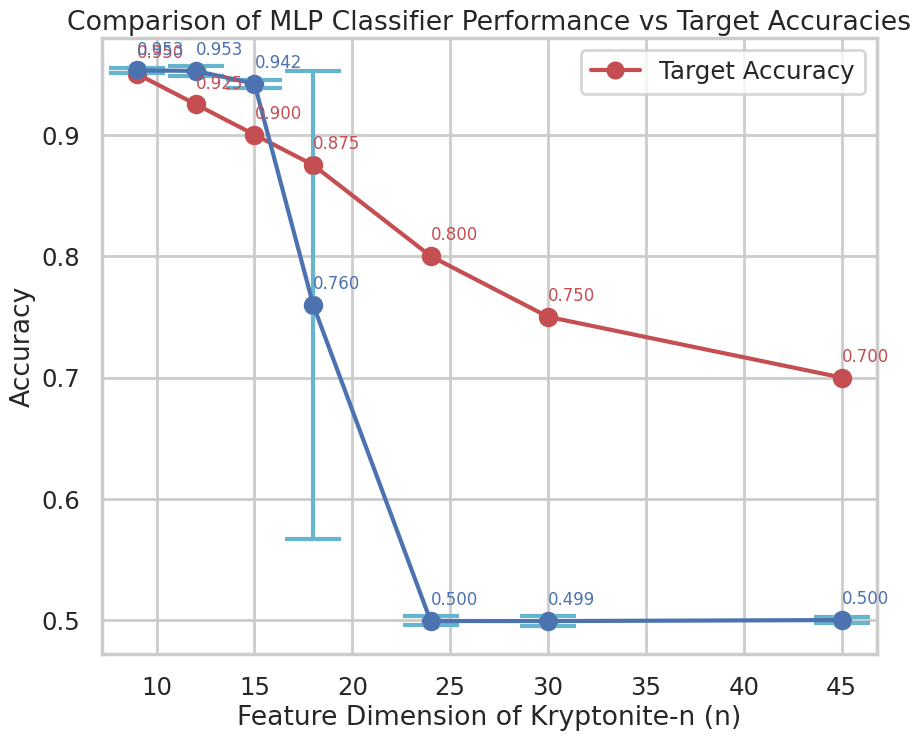

In [8]:
# Plot the performance of models, compare with target accuracies
n = [9, 12, 15, 18, 24, 30, 45]
target_accuracies = [0.95, 0.925, 0.9, 0.875, 0.8, 0.75, 0.7]

# Plotting settings
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.figure(figsize=(10, 8))

# Plotting MLPC performance
plt.errorbar(dimensions, means, yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=20, capthick=3)
plt.scatter(dimensions, means, color='b')

# Plotting target accuracies
plt.plot(n, target_accuracies, label='Target Accuracy', marker='o', linestyle='-', color='r')
plt.scatter(n, target_accuracies, color='r')

# Annotating target accuracies
ax = plt.gca()
for j, (x, y) in enumerate(zip(n, target_accuracies)):
    ax.text(x, y + 0.01, f'{y:.3f}', ha='left', va='bottom', color='r', size=12)
for j, (x, y) in enumerate(zip(n, means)):
    ax.text(x, y + 0.01, f'{y:.3f}', ha='left', va='bottom', color='b', size=12)

# Titles and labels
plt.title("Comparison of MLP Classifier Performance vs Target Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Feature Dimension of Kryptonite-n (n)")
plt.legend()

# Show the plot
plt.show()